# EEL840-KDD-CUP-99

Trabalho realizado por Lucas Rolim e Yago Carvalho para a disciplina EEL840 - Tópicos Especiais em Sistemas de Comunicação
 
## Contexto do tema abordado
 
Nossa proposta é analisar o dataset do KDD Cup de 1999 contendo dados de diversos 
tipos de ataques simulados pela DARPA na rede da Força Aérea Americana em 1998.
 
Esse dataset contém 4.898.431 registros *(dos quais inicialmente usaremos 10% por limitações computacionais)* e 31 features, sendo elas:


### Variáveis básicas relacionadas ao TCP

| Nome          | Descrição                                            | Tipo   |
|---------------|------------------------------------------------------|--------|
|duration       |número de segundos da conexão                         |contínua|
|protocol_type  |tipo de protoclo usado *(ex: tcp,udp,etc)*            |discreta|
|service        |tipo de servico de rede no destino *(ex: http,telnet)*|discreta|
|src_bytes      |número de bytes transferidos da origem até o destino  |contínua|
|dst_byte       |números de dados transferidos do destino até a origem |contínua|
|flag           |status de erro da conexão                             |discreta|
|land           |1 se a conexão é para o mesmo host/porta              |discreta|
|wrong_fragments|número de fragmentos errados                          |contínua|
|urgent         |número de pacotes urgentes                            |contínua|


### Outras variáveis

| Nome              | Descrição                                                                      | Tipo   |
|-------------------|--------------------------------------------------------------------------------|--------|
|hot                |número de *hot indicators*                                                      |contínua|
|num_failed_logins  |número de tentativas de login que falharam                                      |contínua|
|logged_in          |1 se está logado com sucesso                                                    |discreta|
|num_compromised    |número de condições comprometidas                                               |contínua|
|root_shell         |1 se o *root shell* foi obtido                                                  |discreta|
|su_attempt         |1 se o commando *su root* foi tentado                                           |discreta|
|num_root           |número de acessos do tipo *root*                                                |contínua|
|num_file_creations |número de operações de criação de arquivos                                      |contínua|
|num_shells         |número de shells iniciados                                                      |contínua|
|num_access_files   |número de operações nos arquivos de controle de acesso                          |contínua|
|num_outbound_cmds  |número de comandos de saída em uma sessão FTP                                   |contínua|
|is_hot_login       |1 se o login pertece a list *hot*                                               |discreta|
|is_guest_login     |1 se o login é feito por um convidado                                           |discreta|
|count              |número de conexões para o mesmo host que a conexão atual nos últimos 2 segundos |contínua|
|serror_rate        |% das conexões que possuem SYN error                                            |contínua|
|rerror_rate        |% das conexões que possuem REJ error                                            |contínua|
|same_srv_rate      |% das conexões para o mesmo serviço                                             |contínua|
|diff_srv_rate      |% das conexões para diferentes serviços                                         |contínua|
|srv_cont           |número de conexões para o mesmo serviço que o atual nos últimos 2 segundos      |contínua|
|srv_serror_rate    |% das conexões que possuem SYN error (em conexão de mesmo serviço)              |contínua|
|srv_rerror_rate    |% das conexões que possuem REJ error (em conexão de mesmo serviço)              |contínua|
|srv_diff_host_rate |% das conexões para hosts diferentes                                            |contínua|
 
## Problema específico envolvendo o tema abordado
Conseguir classificar se a detecção um determinado padrão de features caracteriza ou não um ataque. Ainda, descobrir quais são as features que melhor caracterizam cada tipo de ataque.
 
## Proposta de Implementação
 
Para a análise pretendemos testar diversas técnicas de aprendizado de máquina, desde modelos de classificação até modelos de clusterização. Alguns dos exemplos de modelos que pretendemos testar são regressão logística, k-means, classificadores bayesianos, redes neurais e SVMs. Além disso, pretendemos criar visualizações eficientes e que permitam extrair informações interessantes​ ​dos​ ​dados,​ ​tais​ ​como​ ​histogramas,​ ​boxplots,​ ​matrizes​ ​de​ ​covariância​ ​e​ ​afins.
 
## Resultados esperados
Esperamos ser capazes de classificar com um grau maior que 70% de certeza se um conjunto de features caracteriza um ataque ou não. Além disso, pretendemos descobrir as 3 features que melhor caracterizam cada tipo de ataque (DoS,  Probins, R2L & U2R).
 

----

Implementação do trabalho
----

------

In [15]:
# Importing libraries
%matplotlib inline
import os
import numpy                   as np
import pandas                  as pd
import matplotlib              as pl
import seaborn                 as sns
import graphviz
from  sklearn.model_selection  import train_test_split
from  sklearn.tree             import DecisionTreeClassifier
from  sklearn.neural_network   import MLPClassifier
from  sklearn.metrics          import accuracy_score
from  sklearn                  import tree
from  sklearn.metrics          import confusion_matrix

# Análise Exploratória

Visando entender melhor o problema, vamos explorar o conjunto de dados e criar algumas visualizações que permitam um melhor entendimento sobre suas principais características. Basicamente, nessa etapa temos o objetivo de checar se as características gerais dos dados estão de acordo com o que é descrito na literatura e também pretendemos gerar *insights* que ajudem a entender melhor os modelos de classificação que vamos criar na etapa seguinte.


Primeiro, vamos começar lendo o conjunto de dados e definindo o nome correto para suas colunas. Além disso, vamos criar dois conjuntos de dados para auxiliar na criação das visualizações, um contendo apenas variáveis discretas/categóricas e outro com as variáveis contínuas.

In [4]:
## Reading .csv files
df = pd.read_csv("data/corrected.csv",sep=',',header=None)

## Defining columns
col_names  = pd.read_csv("data/column_names.csv",sep=',',header=None)[0].values
df.columns = col_names


## Identifying columns as categorical or not
categorical_columns = ["protocol_type","service","flag","land","logged_in","root_shell","su_attempted",
                       "is_host_login","is_guest_login","label"]

df_categorical      = df[categorical_columns]
df_non_categorical  = df.drop(categorical_columns, axis=1)

Podemos perceber que ao analisar a média e o desvio padrão das variáveis não é possível extrair muita informação útil além do fato de notar uma alta variância em quase todas as features, o que mostra que os fluxos de rede coletados são bastante heterogêneos.

In [5]:
## A glance at the non categorical data
df_non_categorical.describe()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,num_root,num_file_creations,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,311029.000000,3.110290e+05,3.110290e+05,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,...,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000
mean,17.902736,1.731702e+03,7.479937e+02,0.000762,0.000051,0.014677,0.002363,0.011243,0.008359,0.000958,...,235.282681,199.193914,0.793494,0.024953,0.547919,0.004566,0.058764,0.058791,0.142659,0.141693
std,407.644400,1.276567e+05,1.612018e+04,0.040367,0.009821,0.312068,0.049990,1.958325,2.165196,0.193119,...,60.913298,100.306470,0.387090,0.096003,0.491963,0.035773,0.231296,0.232997,0.344380,0.346573
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.050000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,244.000000,0.970000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.010000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,57715.000000,6.282565e+07,5.203179e+06,3.000000,3.000000,101.000000,4.000000,796.000000,878.000000,100.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Análise de variáveis discretas


### Relação entre Ataques e Serviços de Rede

Vamos começar analisando a relação entre o serviço de rede utilizado pelo destino dos pacotes e os ataques identificados. Para tal, vamos plotar um gráfico de barras que mostra o percentual de participação de cada serviço de rede em cada ataque.

**De modo a facilitar a visualização, vamos considerar apenas ataques que representem ao menos 1% do percentual total de ataques ou tipos de serviço de rede.**



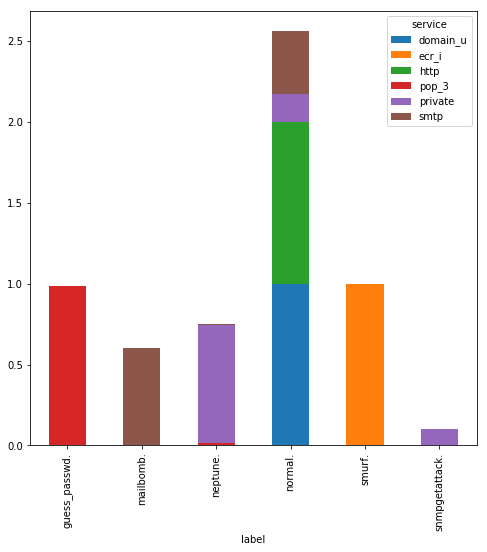

In [6]:
## Create a subset of main dataset (f_data) that contains only services and labels that represents at
## least 1% of the total cases

f_services = pd.crosstab(index=df["service"],columns="count")
f_services = f_services/len(df)
f_services = f_services[f_services["count"] > 0.01]

f_attacks = pd.crosstab(index=df["label"],columns="count")
f_attacks = f_attacks/len(df)
f_attacks = f_attacks[f_attacks["count"] > 0.01]

f_data = df[df['service'].isin(list(f_services.index))]
f_data = f_data[f_data['label'].isin(list(f_attacks.index))]

## Create the plot

attack_data = pd.crosstab(index = f_data["label"], columns=f_data["service"])
frequency_table_attack = (attack_data/attack_data.sum())

frequency_table_attack.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=True);

Através do gráfico acima já é possível conhecer algumas características importantes dos dados, tais quais os principais tipos de ataque presente e de protocolo de serviço utilizados.

Vemos que claramente a maior parte do fluxo de rede presente no conjunto de dados é caracterizada como ¨normal¨, ou seja, um fluxo de rede sem nenhum tipo de atividade maliciosa detectada. Além disso, **os principais ataques que estão presentes nos dados são SYN Flood (Neptune),guess_passord, mailbomb e Smurf.**

### Relação entre Ataques e Tipos de Protocolo

Utilizando a mesma abordagem anterior, iremos avaliar o percentual de participcação de cada protocolo de rede em cada tipo de ataque.

O objetivo desse análise é visualizar se existe alguma característica que foge do conhecido pela literatura.

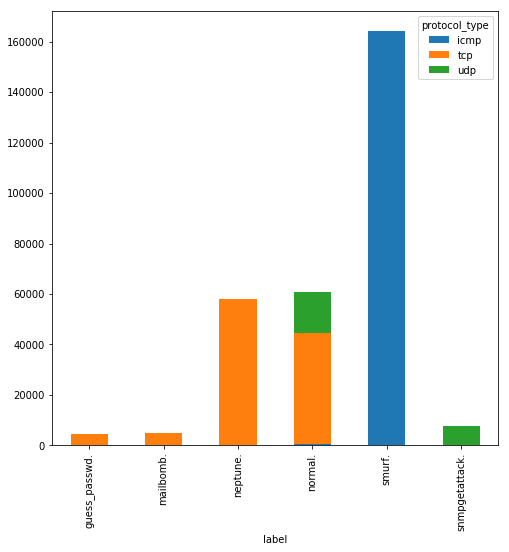

In [7]:
## Create a subset of main dataset (f_data) that contains only protocols and labels that represents at
## least 1% of the total cases

f_protocol = pd.crosstab(index=df["protocol_type"],columns="count")
f_protocol = f_protocol/len(df)
f_protocol = f_protocol[f_protocol["count"] > 0.01]

f_data = df[df['protocol_type'].isin(list(f_protocol.index))]
f_data = f_data[f_data['label'].isin(list(f_attacks.index))]

## Create a Two-Way Table

relationship_protocoal_attack = pd.crosstab(index=f_data["label"], 
                          columns=f_data["protocol_type"])
## Plot the Two-Way Table
relationship_protocoal_attack.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=True);

Como já era esperado pelo conhecimento da literatura, ataques do tipo SYN Flood *(Neptune)* ocorreram em redes com protocolo TCP e ataques Smurf em redes ICMP.Também podemos notar que os ataques do tipo SNMP foram feitos exclusivamente em redes que utizam UDP.

### Participação percentual de cada tipo de protocolo de rede

O gráfico abaixo visa dar uma visão geral da participação de cada tipo de protocolo na rede na qual os dados foram coletados.

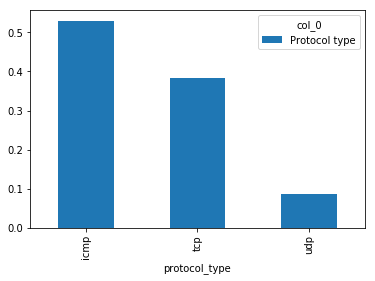

In [8]:
## Create a cross tab dataframe
protocol_data = pd.crosstab(index = df["protocol_type"],columns="Protocol type")
frequency_table_protocol = (protocol_data/protocol_data.sum())

## Plot the dataframe
frequency_table_protocol.plot.bar();

## Análise de variáveis contínuas

### Análise dos usuários logados no sistema

Julgamos interessante avaliar o padrão de comportamento dos usuários que de alguma forma estão logados na rede. Dessa forma, iremos criar gráficos que analisam se alguma ameaça foi detectada para os seguintes tipos de usuários:

- usuários logados como convidados;
- usuários na lista de ¨hot¨.

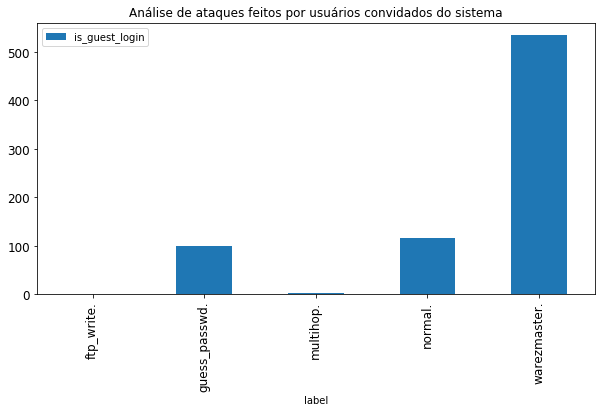

In [9]:
df_temp = df[["is_guest_login","label"]]
df_temp = df_temp.loc[df_temp['is_guest_login'] == 1]
df_temp.groupby(["label"]).count().plot(kind='bar', title ="Análise de ataques feitos por usuários convidados do sistema", figsize=(10, 5), legend=True, fontsize=12)

**Podemos notar que todos os ataques identificados nessa categoria de usuários são do tipo R2L** *(remote to local)*.

Ataques desse tipo ocorrem quando um atacante tem a habilidadede enviar pacotes para uma máquina através da rede, mas não tem uma conta nessa máquina e explora alguma vulnerabilidade para ganhar acesso local como usuário da máquina. Ou seja, provavelmente esses ¨usuários convidados¨ identificados provavelmente tiveram seu login hackeado pelo atacante.

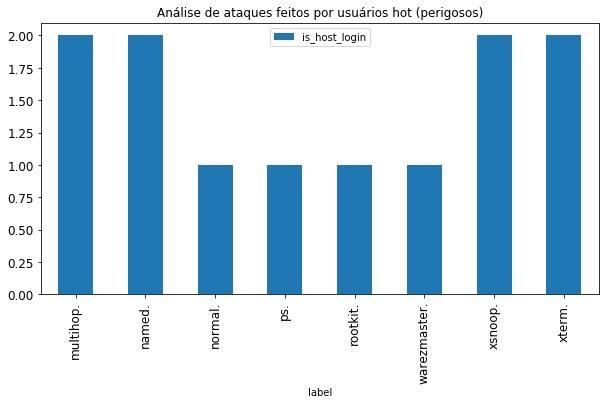

In [10]:
df_temp = df[["is_host_login","label"]]
df_temp = df_temp.loc[df_temp["is_host_login"] == 1]
df_temp.groupby(["label"]).count().plot(kind='bar', title ="Análise de ataques feitos por usuários hot (perigosos)", figsize=(10, 5), legend=True, fontsize=12)

Nesse caso temos também ataques do tipo **U2R** *(User to Root attack)*. Nesse caso o atacante acessa o sistema como usuário normal *(ganho por : sniffing password, um dicionário local ou engenharia social)* e passa a explorar vulnerabilidades para ganhar acesso como root ao sistema.


## Análise de dados redundantes

De acordo com Tavallaee (2009), o grande número de registros redundantes pode enviesar os classificadores para os registros mais frequentes. Dessa forma, o autor propõe um novo dataset, removendo as duplicatas. Assim, analisaremos o dataset KDD99 completo e o sem as duplicatas. Para tal analisaremos a razão entre os dados únicos e os duplicados e plotaremos os gráficos de relação entre os ataques e serviços, e entre os ataques e protocolos utilizados.

In [11]:
# Removing dupicates
df_no_duplicates = df.drop_duplicates()
percentage = 1 - float(df_no_duplicates["protocol_type"].count())/float(df["protocol_type"].count())
print("\n O dataset sem duplicatas é {}% menor que o dataset original,".format(round(percentage * 100,2)))


 O dataset sem duplicatas é 75.15% menor que o dataset original,


# Modelos de classificação

Antes de executar nossos modelos, vamos realizar algumas modificações em nosso conjunto de dados. São elas:

#### 1. Transformar categorias que são strings em categorias numéricas
Essa transformação é necessária para que possamos utilizar as variáveis literais nos modelos, pois alguns só tem suporte a variáveis numéricas

#### 2. Atribuir uma categoria binária de ataque ou não ataque para cada um dos registros  
A principal função de IDS é detectar se um ataque está ou não acontecendo, independente do tipo dele. Dessa forma, fizemos a binarização da classificação a fim de descobrir como os modelos se comportam na detecção de ataques de maneira genérica, podendo ser utilizado em um IDS real.

#### 3. Criar um conjunto de dados para treino e outro para teste e validação dos modelos, usando a proporção (0.8/0.2)



In [12]:
# Mapping strings categories to int

df_binary = df.copy()
df_binary.loc[df_binary.label != 'normal.','label']= 1
df_binary.loc[df_binary.label == 'normal.','label']= 0

df_binary_duplicates = df_no_duplicates.copy()
df_binary_duplicates.loc[df_binary_duplicates.label != 'normal.','label']= 1
df_binary_duplicates.loc[df_binary_duplicates.label == 'normal.','label']= 0


c1 = df_binary.protocol_type.unique()
c2 = df_binary.service.unique()
c3 = df_binary.flag.unique()

d_protocol = {}
d_service = {}
d_flag = {}

for i in range(len(c1)):
    d_protocol[c1[i]] = i

for i in range(len(c2)):
    d_service[c2[i]] = i
    
for i in range(len(c3)):
    d_flag[c3[i]] = i

    
for i in d_protocol:
    df_binary        = df_binary.replace(i, d_protocol[i])
    df_binary_duplicates = df_binary_duplicates.replace(i, d_protocol[i])
    df_no_duplicates = df_no_duplicates.replace(i, d_protocol[i])
    df               = df.replace(i, d_protocol[i])
for i in d_service:
    df_binary        = df_binary.replace(i, d_service[i])
    df_binary_duplicates = df_binary_duplicates.replace(i, d_service[i])
    df_no_duplicates = df_no_duplicates.replace(i, d_service[i])
    df               = df.replace(i, d_service[i])
for i in d_flag:
    df_binary        = df_binary.replace(i, d_flag[i])
    df_binary_duplicates = df_binary_duplicates.replace(i, d_flag[i])
    df_no_duplicates = df_no_duplicates.replace(i, d_flag[i])
    df               = df.replace(i, d_flag[i])

import random
random.seed(1610)

## Split the data in train and test datasets (with duplicates)

df_b = df_binary.copy()
y_b = pd.factorize(df_b['label'])[0]
df_b = df_b.drop('label', 1)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(df_b, y_b, test_size=0.2, random_state=42)


## Split the data in train and test datasets (without duplicates)
df_b_nd = df_binary_duplicates.copy()
y_b_nd = pd.factorize(df_b_nd['label'])[0]
df_b_nd = df_b_nd.drop('label', 1)
X_train_bnd, X_test_bnd, y_train_bnd, y_test_bnd = train_test_split(df_b_nd, y_b_nd, test_size=0.2, random_state=42)


# Dataset (non binary) with duplicates

df_temp = df.copy()
y = df_temp['label']
df_temp = df_temp.drop('label', 1)
X_train, X_test, y_train, y_test = train_test_split(df_temp, y, test_size=0.2, random_state=42)

# Dataset (non binary) without duplicates

df_nd  = df_no_duplicates.copy()
y_nd = df_nd['label']
df_nd = df_nd.drop('label', 1)
X_train_nd, X_test_nd, y_train_nd, y_test_nd = train_test_split(df_nd , y_nd, test_size=0.2, random_state=42)

In [14]:
for i in d_service:
    print(d_service[i], i)

0 private
1 domain_u
2 http
3 smtp
4 ftp_data
5 ftp
6 eco_i
7 other
8 auth
9 ecr_i
10 IRC
11 X11
12 finger
13 time
14 domain
15 telnet
16 pop_3
17 ldap
18 login
19 name
20 ntp_u
21 http_443
22 sunrpc
23 printer
24 systat
25 tim_i
26 netstat
27 remote_job
28 link
29 urp_i
30 sql_net
31 bgp
32 pop_2
33 tftp_u
34 uucp
35 imap4
36 pm_dump
37 nnsp
38 courier
39 daytime
40 iso_tsap
41 echo
42 discard
43 ssh
44 whois
45 mtp
46 gopher
47 rje
48 ctf
49 supdup
50 hostnames
51 csnet_ns
52 uucp_path
53 nntp
54 netbios_ns
55 netbios_dgm
56 netbios_ssn
57 vmnet
58 Z39_50
59 exec
60 shell
61 efs
62 klogin
63 kshell
64 icmp


In [13]:
# Creating array of dicts containing datasets
models = [{"name":"Binario com duplicatas","X":X_train_b,"Y":y_train_b,"X_test":X_test_b,"Y_test":y_test_b, "slug":"b"},
         {"name":"Binario sem duplicatas","X":X_train_bnd,"Y":y_train_bnd,"X_test":X_test_bnd,"Y_test":y_test_bnd, "slug":"bnd"},
         {"name":"Nao binario com duplicatas","X":X_train,"Y":y_train,"X_test":X_test,"Y_test":y_test, "slug":"nb"},
         {"name":"Nao binario sem duplicatas","X":X_train_nd,"Y":y_train_nd,"X_test":X_test_nd,"Y_test":y_test_nd, "slug":"nbnd"}]

## Naives Bayes

O primeiro modelo que iremos testar para a classificação é o Naives Bayes. Esse modelo é baseado no Teorema de Bayes e faz a suposição que todas as variáveis são independentes entre si, o que nós não acreditamos que seja uma verdade. Visto isso, é esperado que esse seja o modelo que alcance o pior desempenho destre todos que iremos testar.

In [17]:
from sklearn.naive_bayes import GaussianNB
for i in range(len(models)):
    gnb = GaussianNB()
    gnb.fit(models[i]["X"],models[i]["Y"])
    print("A acurácia do modelo {} foi de: {}".format(models[i]["name"],gnb.score(models[i]["X_test"],models[i]["Y_test"])))
    if (i < 2):
        tn, fp, fn, tp = confusion_matrix(models[i]["Y_test"], gnb.predict(models[i]["X_test"])).ravel()
        print("\nO recall e: {}".format(tp/(tp+fn)))
        print("A precisao e: {}".format(tp/(tp+fp)))
    print("\n ------------------------------------\n")

A acurácia do modelo Binario com duplicatas foi de: 0.925602031958332

O recall e: 0.922871598741086
A precisao e: 0.9839442721828144

 ------------------------------------

A acurácia do modelo Binario sem duplicatas foi de: 0.9102788019923669

O recall e: 0.8350033400133601
A precisao e: 0.9260974254491573

 ------------------------------------

A acurácia do modelo Nao binario com duplicatas foi de: 0.922049320001286

 ------------------------------------

A acurácia do modelo Nao binario sem duplicatas foi de: 0.7737240442460702

 ------------------------------------



## Multilayer Perceptron

In [18]:
for i in range(len(models)):
    clf_mlp = MLPClassifier(solver='adam', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
    clf_mlp.fit(models[i]["X"],models[i]["Y"])
    print("A acurácia do modelo {} foi de: {}".format(models[i]["name"],clf_mlp.score(models[i]["X_test"],models[i]["Y_test"])))
    if (i < 2):
        tn, fp, fn, tp = confusion_matrix(models[i]["Y_test"], clf_mlp.predict(models[i]["X_test"])).ravel()
        print("\nO recall e: {}".format(tp/(tp+fn)))
        print("A precisao e: {}".format(tp/(tp+fp)))
    print("\n ------------------------------------\n")

A acurácia do modelo Binario com duplicatas foi de: 0.9321930360415394

O recall e: 0.9997012071232222
A precisao e: 0.9227247655819084

 ------------------------------------

A acurácia do modelo Binario sem duplicatas foi de: 0.9157125299178472

O recall e: 0.7909151636606546
A precisao e: 0.989346145811573

 ------------------------------------

A acurácia do modelo Nao binario com duplicatas foi de: 0.7194643603510915

 ------------------------------------

A acurácia do modelo Nao binario sem duplicatas foi de: 0.9298790348664209

 ------------------------------------



## Modelos em Árvores

### Modelos baseados em Gini vs Modelos baseados em Entropia

Os algoritmos para construir árvores de regressão geralmente utilizam uma abordagem do tipo *top-down*, escolhendo a cada passo uma variável para separar os dados em novos subconjuntos e por fim em classes. Diferentes algoritmos utilizam diferentes métricas para definir qual é a melhor variável para dividir os dados em um novo subcojunto e são exatamente essas métricas que desejamos explorar nessa secção. 

Iremos testar dois tipos de modelo de árvore de regressão, baseadas na métrica de Gini e na métrica de Entropia. Dessa forma, vamos explicar brevemente como é calculada cada uma dessas medidas e quais são suas principais diferencças.

#### Gini Impurity

$$\mathit{Gini}(E) = 1 - \sum_{j=1}^{c}p_j^2$$

Esse é um índice muito utilizado na área de economia, principalmente para avaliar a desigualdade social de um país. Ele basicamente avalia a quantidade de valores que foi classificado de maneira correta em cada classe em cada umas das possibilidades de divisão dispoíveis. Feito isso ele calcula o índice para cada uma das novas subdivisões e pondera pelo número de elementos que foi atribuído a cada uma delas.

![](imagens/m-gini.png)

#### Função de ganho de informação


Essa medida se baseia no conceito de **entropia** de Teoria a Informação. A implementação de árvore utilizando essa métrica é tão conhecida que recebeu um nome próprio, C.45. Para cada nó da árvore o valor de informação representa ¨a quantidade esperada de informação que seria necessária para classificar qualquer novo dado como *sim* ou *não*, dado que esse dado chegou até o nó atual na árvore¨. Basicamente, queremos dividir nossa árvore até que essa quantidade de informação seja zero.

Nossa função de entropia é:

$$\textit{Entropy}: H(E) = -\sum_{j=1}^{c}p_j\log p_j$$

E a função de ganho de informação é dada por:

$$IG(E,a) = H(E) - H(E|a)$$

Dados esses esclarecimentos, vamos testar os dois modelos que se utilizam desse conceito: Florestas Aleatórias e Árvores de Decisão.

## Random Forest

O modelo de Florestas aleatórias nada mais é do que um conjunto de Árvores de Regressão criadas com a escolha dos parâmetros de divisão feita de maneira aleatória e que em conjunto votam para a criação de uma ¨arvore final¨ de decisão.

Este é um dos modelos mais usados na área de Machine Learning na atualidade e em grande parte dos casos o que obtém o melhor custo benefício entre resultado/tempo e poder computacional despendido.


![](imagens/random-forest.png?raw=true)

In [15]:
from sklearn.ensemble import RandomForestClassifier
rd_array = []
for i in range(len(models)):
    randomForest = RandomForestClassifier(criterion  = "entropy")
    rd_array.append(randomForest.fit(models[i]["X"],models[i]["Y"]))

In [16]:
# import matplotlib.pyplot as plt
for j in range(len(models)):
    featuresImportance = {}
    for i in range(len(df.columns[:len(df.columns)-1])):
        featuresImportance[df.columns[:len(df.columns)-1][i]] = rd_array[j].feature_importances_[i]

    s = [(k, featuresImportance[k]) for k in sorted(featuresImportance, key=featuresImportance.get, reverse=True)]

    print("As 5 features mais relevantes para o modelo %s foram: \n"% (models[j]["name"])) 
    for i in range (5):
        print("%s, com influência: %s" % (s[i][0],s[i][1]))

    print("\nA acurácia do modelo foi de: {} \n".format(rd_array[j].score(models[j]["X_test"], models[j]["Y_test"])))
    if(j <= 1):
        tn, fp, fn, tp = confusion_matrix(models[j]["Y_test"], rd_array[j].predict(models[j]["X_test"])).ravel()
        print("O recall e: {}".format(tp/(tp+fn)))
        print("A precisao e: {}".format(tp/(tp+fp)))
        print("\n ------------------------------------\n")
    

As 5 features mais relevantes para o modelo Binario com duplicatas foram: 

service, com influência: 0.172331447961
dst_bytes, com influência: 0.164565439485
src_bytes, com influência: 0.1143402556
count, com influência: 0.107283294633
dst_host_count, com influência: 0.0713520182712

A acurácia do modelo foi de: 0.9814969617078738 

O recall e: 0.988765387833154
A precisao e: 0.988312593330015

 ------------------------------------

As 5 features mais relevantes para o modelo Binario sem duplicatas foram: 

src_bytes, com influência: 0.168073524775
dst_host_srv_count, com influência: 0.123337023799
diff_srv_rate, com influência: 0.1088813828
dst_bytes, com influência: 0.0763506723039
count, com influência: 0.0639773784241

A acurácia do modelo foi de: 0.9952778316838088 

O recall e: 0.9936539746158984
A precisao e: 0.9941520467836257

 ------------------------------------

As 5 features mais relevantes para o modelo Nao binario com duplicatas foram: 

srv_count, com influência: 0.1450

Nesse caso, os resultados utilizando as métricas de Gini e Entropia foram praticamente idênticos, dessa forma decidimos omitir os resutados obtidos por Gini de modo a não poluir esse relatório *(para visualizá-los para ir no bloco 15 e mudar de **entropy** para **gini**)*.

Em primeiro lugar, podemos perceber que a acurácia foi bastante elevada em todos os casos e acabou subindo no modelo sem duplicatas, provavelmente pela redução de *overfitting* em algum nível. Como a acurácia resultou em um valor extremamente preciso, recorremos ao Recall e a Precisão para verificar se nossos resultados eram válidos. Ambos os indicadores sinalizaram de maneira positiva.

Podemos notar também que, apesar de variações na ordem, algumas variáveis se mostraram importantes para a divisão em todos os casos, sendo as com mais destaque **service**, **flag** e **src_bytes**. Isso vai ao encontro com o que havíamos encontrado na análise exploratória, que mostrava que os ataques mais comuns nessa rede eram SYN Flood e Smurf.

## Árvores de Decisão

As árvores de decisão são um tipo de modelagem estatística que recebe como entrada um conjunto de dados já classificados e, a partir dos dados de entrada, classifica dados de acordo com os padrões aprendidos. 
O algoritmo utilizado no modelo é o CART (Classification And Regression Tree), que é bastante similar ao C.45 mencionado anteriormente, mas com suporte a variáveis numéricas.

### Gini

In [20]:
names = col_names[:len(col_names)-1]

for i in range(len(models)):
    clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=5, min_samples_leaf=5)
    clf_gini.fit(models[i]["X"],models[i]["Y"])
    tree.export_graphviz(clf_gini, out_file='imagens/tree_gini_{}.dot'.format(models[i]["slug"]),feature_names = names,class_names = df.label.unique(),filled = True)
    success = os.system("dot -Tpng imagens/tree_gini_{}.dot -o imagens/tree_gini_{}.png".format(models[i]["slug"], models[i]["slug"]))
    print("A acurácia do modelo {} foi de: {}".format(models[i]["name"],clf_gini.score(models[i]["X_test"],models[i]["Y_test"])))
    if (i < 2):
        tn, fp, fn, tp = confusion_matrix(models[i]["Y_test"], clf_gini.predict(models[i]["X_test"])).ravel()
        print("\nO recall e: {}".format(tp/(tp+fn)))
        print("A precisao e: {}".format(tp/(tp+fp)))
    print("\n ------------------------------------\n")

A acurácia do modelo Binario com duplicatas foi de: 0.9589428672475324

O recall e: 0.9507190948567786
A precisao e: 0.9983266398929049

 ------------------------------------

A acurácia do modelo Binario sem duplicatas foi de: 0.9877094249304612

O recall e: 0.9911489645958583
A precisao e: 0.977437417654809

 ------------------------------------

A acurácia do modelo Nao binario com duplicatas foi de: 0.9470629842780439

 ------------------------------------

A acurácia do modelo Nao binario sem duplicatas foi de: 0.9605407853030598

 ------------------------------------



### Entropia

In [21]:
for i in range(len(models)):
    clf_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 100,max_depth=5, min_samples_leaf=5)
    clf_entropy.fit(models[i]["X"],models[i]["Y"])
    tree.export_graphviz(clf_entropy, out_file='imagens/tree_entropy_{}.dot'.format(models[i]["slug"]),feature_names = names,class_names = df.label.unique(),filled = True)
    success = os.system("dot -Tpng imagens/tree_entropy_{}.dot -o imagens/tree_entropy_{}.png".format(models[i]["slug"], models[i]["slug"]))
    print("A acurácia do modelo {} foi de: {}".format(models[i]["name"],clf_entropy.score(models[i]["X_test"],models[i]["Y_test"])))
    if (i < 2):
        tn, fp, fn, tp = confusion_matrix(models[i]["Y_test"], clf_entropy.predict(models[i]["X_test"])).ravel()
        print("\nO recall e: {}".format(tp/(tp+fn)))
        print("A precisao e: {}".format(tp/(tp+fp)))
    print("\n ------------------------------------\n")

A acurácia do modelo Binario com duplicatas foi de: 0.959232228402405

O recall e: 0.9507589339070156
A precisao e: 0.9986609197807256

 ------------------------------------

A acurácia do modelo Binario sem duplicatas foi de: 0.9869978653211722

O recall e: 0.9854709418837675
A precisao e: 0.9810473815461347

 ------------------------------------

A acurácia do modelo Nao binario com duplicatas foi de: 0.956949490402855

 ------------------------------------

A acurácia do modelo Nao binario sem duplicatas foi de: 0.966621385600621

 ------------------------------------



### Árvores de decisão usando o critério Gini
#### Dataset com duplicatas e não binarizado
![DecisionTree Gini](imagens/tree_gini_nb.png "DecisionTree Gini com duplicatas e não binarizado")
#### Dataset sem duplicatas e não binarizado
![DecisionTree Gini](imagens/tree_gini_nbnd.png "DecisionTree Gini sem duplicatas e não binarizado")
#### Dataset com duplicatas e binarizado
![DecisionTree Gini](imagens/tree_gini_b.png "DecisionTree Gini com duplicatas e binarizado")
#### Dataset sem duplicatas e binarizado
![DecisionTree Gini](imagens/tree_gini_bnd.png "DecisionTree Gini sem duplicatas e binarizado")
### Árvore de decisão usando o critério Entropia
#### Dataset com duplicatas e não binarizado
![DecisionTree Entropy](imagens/tree_entropy_nb.png "DecisionTree Entropy com duplicatas e não binarizado")
#### Dataset sem duplicatas e não binarizado
![DecisionTree Entropy](imagens/tree_entropy_nbnd.png "DecisionTree Entropy sem duplicatas e não binarizado")
#### Dataset com duplicatas e binarizado
![DecisionTree Entropy](imagens/tree_entropy_b.png "DecisionTree Entropy com duplicatas e binarizado")
#### Dataset sem duplicatas e binarizado
![DecisionTree Entropy](imagens/tree_entropy_bnd.png "DecisionTree Entropy sem duplicatas e binarizado")

### Análise das Árvores de Decisão do dataset sem duplicatas e não binarizado

*(Para uma melhor visualização das árvores acesse a pasta ¨imagens¨ desse repositório)*

Vamos adotar analisar cada uma das árvores separadamente e depois atribuir um parecer sobre suas diferenças e semelhanças. Começaremos pela árvore que utiliza pela métrica de Gini, para logo após analisar a árvore de regressão que utiliza como métrica a função de ganho.

#### Análise da árvore de decisão usando Gini

O primeiro ponto importante a se notar é a raíz dessa árvore. Nesse caso, temos que a variável utilizada para maximizar a subdivisão em dois novos grupos é a variável **flag**, que indica o status de erro identificado na conexão. Essa variável foi transformada de string para numérica para aplicarmos os modelos, a relação atribuída foi:

{'OTH': 10,'REJ': 3,'RSTO': 5,'RSTOS0': 8,'RSTR': 1,'S0': 6,'S1': 2,'S2': 7,'S3': 4,'SF': 0,'SH': 9}

Ainda, o significado de cada um desses status é:

![](imagens/flags.png?raw=true)

Ou seja, ao separar os novos grupos de acordo com uma divisão por valores de flags menores iguais a 2.5 o que o algoritmo está fazendo é tentando separar as conexões que foram estabelecidas e terminadas normalmente das demais. A classe que foi atribuída foi a **udpstorm**, uma classe que possui somente duas apariçoẽs no dataset, portanto não conseguimos compreender o motivo dela ter sido a escolhida. Nossa expectativa era que a classificação da raíz fosse ¨normal¨, pois é a classificação que mais aparece.

Algumas comparações interessantes com o que estudamos na matéria podem ser vistas, por exemplo, na ramificação que divide entre as classificações de **¨buffer_overflow¨ e ¨mscan¨**. Enquanto o buffer overflow é um ataque que explora o fato de quando o buffer estar cheio as informações irem para a pilha e se aproveita para manipular essas informações, o mscan funciona de forma semelhante a um port scan, no sentido de procurar máquinas com vulnerabilidades para um possível futuro ataque. É interessante notar que a variável escolhida para dividir os dados entre esses dois dados foi a **srv_diff_host_rate**, que siginifica a percentagem de conexões feitas para o mesmo serviço e hosts diferentes. Se essa porcentagem for menor que 0.35 classificamos como ¨mscan¨, que pode ser devido ao fato do mscan ter essa porcentagem por natureza menor em consequência a ele ¨testar¨ diversos serviços distintos para avaliar possíveis vulnerabilidades.

Outro aspecto interessante da árvore que podemos traçar um paralelo com o conteúdo visto em aula é a divisão dos dados entre as categorias **¨smurf¨ e ¨ftpwrite¨**. Ao passo que o smurf é um ataque de DDoS o FTP Write se dá pelo aproveitamento por parte do atacante de uma configuração errada de FTP *(permitindo que ele adicione e remova novos arquivos)*. De acordo com a árvore de decisão, se é identificado em um elemento que estava sendo classificado como ataque Smurf que ele possui **duração de conexão** maior que 279 segundos ele passa a ser classificado como ataque FTP Write. Imaginamos que isso pode ser devido ao fato que um atacante que faz FTP Write pode precisar de mais tempo para, por exemplo, fazer upload de um arquivo malicioso e o configurar na máquina infectada.

#### Análise da árvore de decisão usando entropia

A árvore de decisão utilizando entropia foi em diversos aspectos parecida com a árvore gerada quando utilizamos a métrica de Gini. Contudo, uma diferença que ficou clara foi que, utilizando a mesma profundidade de árvore, ela acabou conseguindo classificar ataques diferentes. Por exemplo, os tipos de ataque ¨back¨ e ¨xterm¨ só aparecem na árvore criada por Entropia, enquanto os ataques ¨Saint¨ e ¨nmap¨ só aparecem usando Gini.

Podemos ter um insight interessante ao analisar o nó que divide ataques do tipo ¨apache2¨ e ¨buffer overflow¨ nessa árvore. Enquanto o apache2 configura um ataque de negação se serviço contra um server web ataque o buffer overflow, como já explicado, se aproveita da manipulação dos dados que cairam em overflow e foram para a stack. O interessante é notar que a variável que dividiu esses dois grupos foi a **¨same_srv_rate¨, que mede a porcentagem de conexões para o mesmo serviço**. O ataque apache2 tende a ter menos conexões para o mesmo serviço, uma vez que o buffer overflow precisa sempre se conectar ao mesmo serviço para agilizar que aconteça overflow.

### Comparação entre as árvores com e sem duplicatas
A fim de analisar a influência que os registros duplicados tem no classificador, refizemos a árvore com o dataset sem duplicatas.

Analisando a árvore gerada com o critério de entropia, podemos perceber que o número de ataques diferentes que o modelo consegue classificar diminui bastante usando o dataset com dados duplicados, sendo **15 tipos diferentes no dataset sem duplicatas contra 9 no dataset com duplicatas**. Além disso a acurácia do modelo sem duplicatas também é maior que a do modelo com duplicatas. Isso mostra que os dados duplicados realmente enviesam o classificador para os registros com maior frequência, e com isso diminui a acurácia do modelo.

Outro ponto é perceber que na árvore com duplicatas o nó raiz é a feature protocol_type, que foi mapeada da seguinte forma:
{'icmp': 2, 'tcp': 1, 'udp': 0}
No classificador, todo tráfego TCP e UDP foi para um ramo da árvore e o ICMP foi para o outro ramo, o que faz algum sentido de acordo com o uso de cada protocolo nas aplicações existentes hoje.

## Referências
 
[1] Dataset: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
 
[2] GIRMA, Anteneh; GARUBA, Mosses; GOEL, Rajini. Advanced Machine Language Approach to Detect DDoS Attack Using DBSCAN Clustering Technology with Entropy. In: Information Technology-New Generations. Springer, Cham, 2018. p. 125-131.
 
[3] LI, Qingru et al. An Intrusion Detection System Based on Polynomial Feature Correlation Analysis. In: Trustcom/BigDataSE/ICESS, 2017 IEEE. IEEE, 2017. p. 978-983.
 
[4]  TAVALLAEE, Mahbod et al. A detailed analysis of the KDD CUP 99 data set. In: Computational Intelligence for Security and Defense Applications, 2009. CISDA 2009. IEEE Symposium on. IEEE, 2009. p. 1-6.
 
[5] Lincoln Laboratory - https://www.ll.mit.edu/ideval/docs/attackDB.html
 
[6] http://shodhganga.inflibnet.ac.in/bitstream/10603/9850/8/08_chapter%203.pdf

[7] http://scikit-learn.org/stable/modules/tree.html#